<a href="https://colab.research.google.com/github/cleysonl/Pytorch/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Recognition - PyTorch**

In [1]:
!pip install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

## **Transformations**

In [3]:
# Chain transformations 
# 1) transforms.Resize(): Make sure all the images are the same size 28x28
# 2)transforms.ToTensor(): Convert our numpy array in the range of 0 to 256 to a tensor in a range of 0 to 1
# 2)transforms.Normalize: Normalize the values for each tensor of image size, channel, height and width. Change the range from 0 to 1 to -1 to 1
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ),(0.5, ))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download = True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download = True, transform=transform)

# Training loader is used to divide the dataset in batches
training_loader = torch.utils.data.DataLoader(dataset= training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

0it [00:00, ?it/s]

9920512it [00:01, 8963088.85it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135579.48it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2221401.61it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 45533.95it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## **Numpy Image Conversion Function**

In [0]:
# Plot a tensor image (color, width, height)
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  # transpose to (width,height, color)
  image = image.transpose(1, 2, 0)
  print(image.shape)
  # image = image * np.array((0.5, )) + np.array((0.5, ))
  # We need to get rid of the third dimension 
  image = image[:,:,0]
  # To ensure that the range of the image is between 0 and 1
  image = image.clip(0,1)
  return image

## **Plotting Image Data**

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


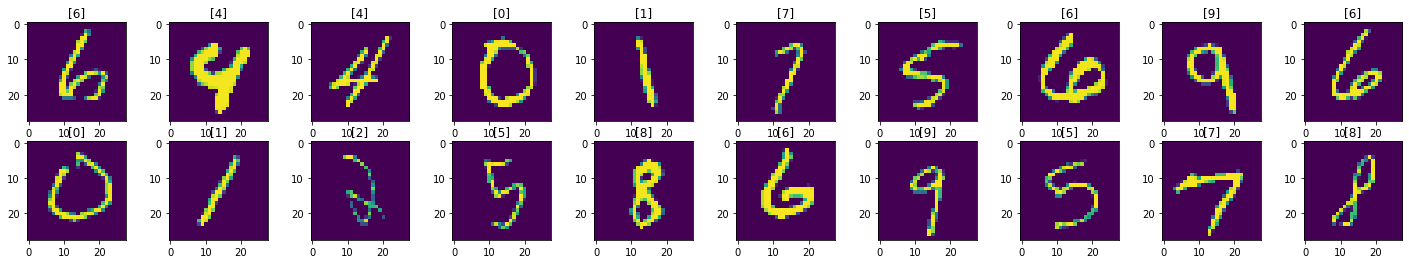

In [5]:
dataiter= iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
  ax= fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

## **Model Class Constructor**

In [0]:
class Classifier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1= nn.Linear(D_in, H1)
    self.linear2= nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  def forward(self, x):
    x= F.relu(self.linear1(x))
    x= F.relu(self.linear2(x))
    x= self.linear3(x)
    return x

# 28*28 = 784 (size of the image)
model = Classifier(784,125,65,10)

## **Loss and Optimizer**

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

## **Training Process**

In [8]:
epochs = 12
# List to save the losses for each epoch
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  # Variable used to acummulate the losses for each batch in an epoch
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader: 
    # Reshape inputs with: inputs.view(inputs.shape[0]= 1, -1 (28*28 = 784))
    inputs = inputs.view(inputs.shape[0], -1)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs,1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss += loss.item()

  else:
    # To save memory add the following line ( it sets temporariy the grad flags into False)
    with torch.no_grad():
    # Run our model on the validation set 
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs,1)
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        val_running_loss += val_loss.item()


    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch:', i+1)

    print('Training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('Validation loss: {:.4f}, acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))


epoch: 1
Training loss: 0.9390, acc: 77.5333
Validation loss: 0.4165, acc: 88.7200
epoch: 2
Training loss: 0.3722, acc: 89.5317
Validation loss: 0.3229, acc: 90.5000
epoch: 3
Training loss: 0.3118, acc: 91.0100
Validation loss: 0.2819, acc: 91.8800
epoch: 4
Training loss: 0.2788, acc: 91.9150
Validation loss: 0.2562, acc: 92.5900
epoch: 5
Training loss: 0.2533, acc: 92.7067
Validation loss: 0.2339, acc: 93.2300
epoch: 6
Training loss: 0.2320, acc: 93.3450
Validation loss: 0.2161, acc: 93.6900
epoch: 7
Training loss: 0.2131, acc: 93.9117
Validation loss: 0.2050, acc: 94.0100
epoch: 8
Training loss: 0.1962, acc: 94.4283
Validation loss: 0.1868, acc: 94.6200
epoch: 9
Training loss: 0.1827, acc: 94.8183
Validation loss: 0.1772, acc: 94.8600
epoch: 10
Training loss: 0.1697, acc: 95.1800
Validation loss: 0.1658, acc: 95.1900
epoch: 11
Training loss: 0.1592, acc: 95.4750
Validation loss: 0.1598, acc: 95.3500
epoch: 12
Training loss: 0.1493, acc: 95.7450
Validation loss: 0.1533, acc: 95.4300


## **Plotting Loss**

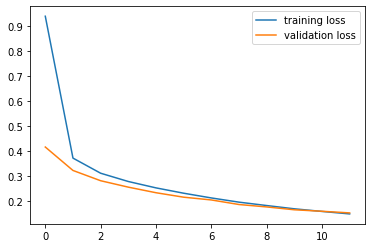

In [9]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

## **Plotting Accuracy**

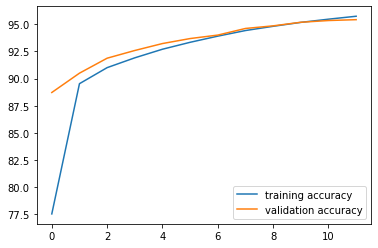

In [10]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

## **Pillow Installation**

In [11]:
!pip3 install pillow==4.0.0

     |████████████████████████████████| 5.6MB 6.3MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
import PIL.ImageOps

## **Show Image**

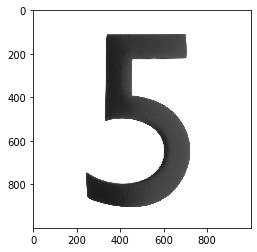

In [13]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg' 
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

## **Pre-processing image**

(28, 28, 1)


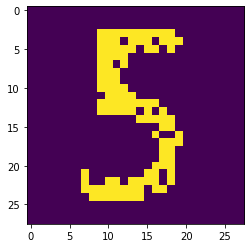

In [14]:
# we need to invert the colors like in out training and validation set -> number white and background black
img = PIL.ImageOps.invert(img)
# Convert to a binary black & white image
img = img.convert('1')
#Transform the image to the right size
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
# Copied this from the training process and changed name of variables
img = img.view(img.shape[0],-1)
output = model(img)
_, pred = torch.max(output,1)
print(pred.item())

5


## **Validation Prediction**

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


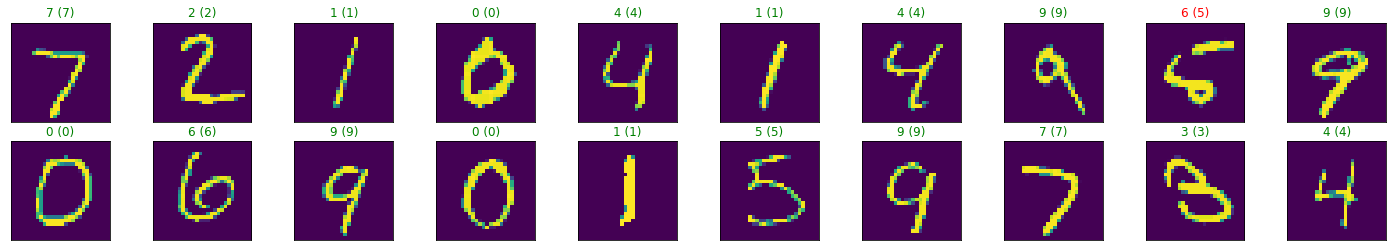

In [16]:
dataiter= iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0],-1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))